In [1]:
import numpy as np
import pandas as pd
import gzip
import argparse
import scipy.stats
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
biovar = 'bio18'

In [3]:
pwd -P

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/kendall_tau_last_gen'

In [4]:
#finalgen_samples = pd.read_csv('../final_gen.csv')['sample_name']
last_gen = pd.read_csv('../key_files/final_gen.csv')['sample_name']
samples = last_gen.to_list()

#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_experimental_sites_era5.csv')

sites_af = pd.Series(samples).str.split('_').str[0].astype(int)

sites_af.name = 'site'

env = sites_af.reset_index().merge(clim_sites_during_exp).drop(['index'],axis=1)

In [5]:
af = pd.read_csv('../key_files/allele_freq_maf05_mincount05_lastgensamples.csv')   

In [6]:
p_bar = af.mean(axis=1)

# Apply the MAF calculation using a lambda function
maf = p_bar.apply(lambda x: 1 - x if x > 0.5 else x)

In [ ]:
#maf.to_csv('../key_files/maf_all_samples_last_gen.csv',index=None)

In [7]:
deltap = pd.read_csv('../key_files/delta_p_maf05_mincount05_lastgensamples.csv')


KeyboardInterrupt



In [8]:
biovars = [
 'bio2',
 'bio3',
 'bio4',
 'bio5',
 'bio6',
 'bio7',
 'bio8',
 'bio9',
 'bio10',
 'bio11',
 'bio13',
 'bio14',
 'bio15',
 'bio16',
 'bio17',
 'bio19']

In [9]:
import pickle
dict_blocks = '../key_files/blocks_snpsid_dict.pkl'

with open(dict_blocks, 'rb') as file:
    dict_blocks = pickle.load(file)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

In [10]:
snps_names = pd.read_csv('../key_files/var_pos_grenenet.csv')
snps_names = snps_names[snps_names['total_alleles05filter_lastgen'].notna()].reset_index(drop=True)

In [13]:
for biovar in biovars:
    print(biovar)
    bio1 = env[biovar]

    kendall = {}
    
    # Iterate through each row in af
    for index, row in af.iterrows():
        # Apply kendalltau to the current row and bio1
        geno_k_tau, geno_k_tau_p_value = scipy.stats.kendalltau(bio1, row)
        kendall[index] = [geno_k_tau,geno_k_tau_p_value]

    kendall = pd.DataFrame(kendall).T
    kendall['MAF'] = maf
    kendall.columns = ["K_tau","K_tau_p", "MAF"]

    
    kendall = pd.concat([snps_names[['id', 'pos', 'chrom']], kendall],axis=1)
    
    kendall['block'] = kendall['id'].map(reverse_mapping) 
    
    kendall.to_csv(f'kendall_corr_{biovar}.csv',index=None)

bio2
bio3
bio4
bio5
bio6
bio7
bio8
bio9
bio10
bio11
bio13
bio14
bio15
bio16
bio17
bio19


In [7]:
kendall = pd.read_csv(f'kendall_corr_{biovar}.csv')

In [9]:
kendall = kendall.sort_values('K_tau_p').head(100)

In [12]:
kendall['block'] = kendall['id'].map(reverse_mapping)

In [13]:
kendall = kendall.drop_duplicates('block')

In [14]:
biovar = 'bio18'

In [17]:
kendall.to_csv(f'top_hits_binom_last_gen_{biovar}.csv')

In [17]:
kendall

,id,pos,chrom,K_tau,K_tau_p,MAF,block
0,1_346,346,1,-0.096142,7.706475e-03,0.288067,1_0
1,1_353,353,1,-0.047444,1.885541e-01,0.077929,1_0
2,1_363,363,1,0.027164,4.515548e-01,0.092449,1_0
3,1_395,395,1,-0.241889,2.073247e-11,0.078113,1_0
4,1_396,396,1,-0.241889,2.073247e-11,0.078113,1_0
...,...,...,...,...,...,...,...
1048630,5_26975078,26975078,5,0.174654,1.296459e-06,0.169091,5_3110
1048631,5_26975121,26975121,5,-0.078267,3.012195e-02,0.069410,5_3110
1048632,5_26975148,26975148,5,-0.078267,3.012195e-02,0.069410,5_3110
1048633,5_26975272,26975272,5,0.034256,3.424033e-01,0.466354,5_3110


In [21]:
kendall.to_csv(f'kendall_corr_{biovar}.csv',index=None)

In [22]:
kendall = pd.read_csv(f'kendall_corr_{biovar}.csv')

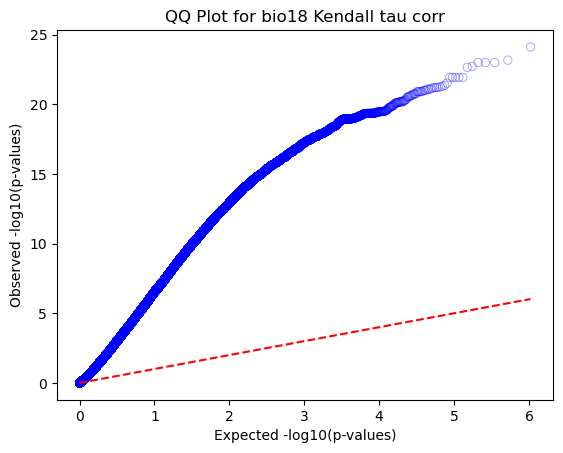

In [23]:
# Sort the p-values in ascending order
observed_quantiles = -np.log10(np.sort(kendall['K_tau_p'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(kendall), 1, len(kendall)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar} Kendall tau corr')

plt.show()

/tmp/ipykernel_642615/36481905.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


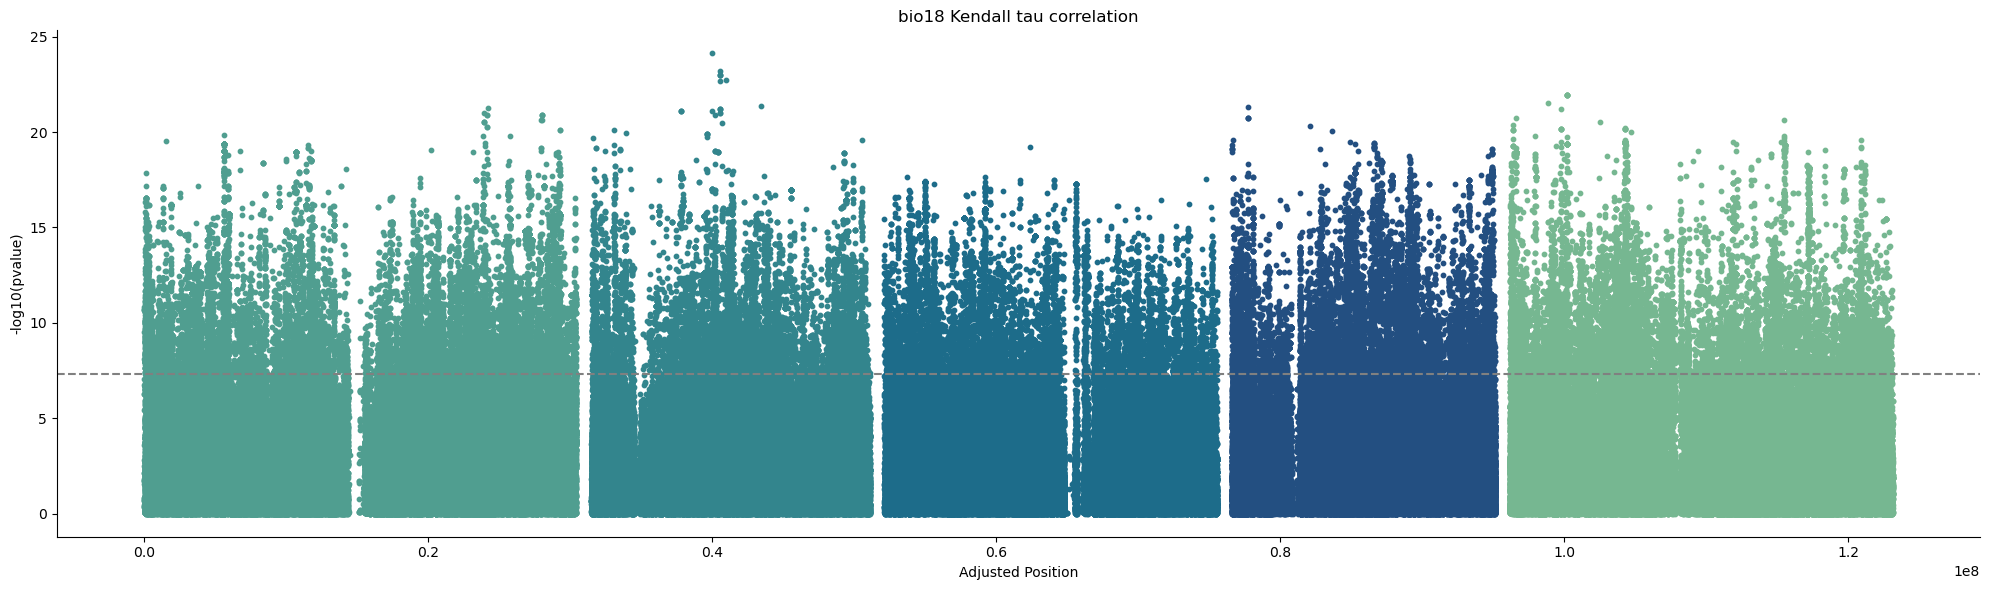

In [24]:
threshold_value = 0.05 / len(kendall)

#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = kendall[['K_tau_p', 'pos', 'chrom']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['K_tau_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} Kendall tau correlation')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_kendall_{biovar}.png')
plt.show()